In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
# leer archivo CSV

strava_diego = pd.read_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\data\activities_diego_llorente.csv")

# mostrar las primeras filas del DataFrame

strava_diego.head()

,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,Intensity,Average Grade Adjusted Pace,Timer Time,Total Cycles,Recovery,With Pet,Competition,Long Run,For a Cause,Media
0,12286569161,"Aug 31, 2024, 7:29:23 AM",Denia 4k 31.8.24,Run,NaN,1227,4.00,NaN,NaN,False,...,NaN,3.268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12312426596,"Sep 3, 2024, 6:32:46 AM",Denia 7K 3.9.24,Run,NaN,2359,7.00,NaN,NaN,False,...,NaN,3.133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12327869051,"Sep 4, 2024, 8:42:36 PM",Madrid noche 8K 4.9.24,Run,NaN,2700,8.00,NaN,NaN,False,...,NaN,3.181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12377627761,"Sep 10, 2024, 6:36:55 PM",5k alegre 10.9.24,Run,NaN,1494,5.01,NaN,NaN,False,...,NaN,3.760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12377934099,"Sep 10, 2024, 7:06:02 PM",6k + suaves 10.9.24,Run,NaN,2189,6.01,NaN,NaN,False,...,NaN,2.969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def limpiar_strava(df):
    # Renombrar columnas 
    df = df.rename(columns={
        'Activity Date': 'activity_date',
        'Activity Type': 'activity_type',
        'Activity Name': 'activity_name',
        'Distance': 'distance',
        'Elapsed Time': 'elapsed_time',
        'Average Speed': 'average_speed',
        'Elevation Gain': 'elevation_gain',
        'Average Heart Rate': 'avg_heart_rate',
        'Max Heart Rate': 'max_heart_rate',
        'Calories': 'calories',
        'Average Cadence': 'avg_cadence',
        'Activity ID': 'activity_id',
        'Filename': 'filename'
    })

    df['activity_date'] = pd.to_datetime(df['activity_date'], errors='coerce')
    df = df[(df['activity_date'].dt.year >= 2024) & (df['activity_type'] == 'Run')]

    if df['distance'].max() > 1000:
        df['distance_km'] = df['distance'] / 1000
    else:
        df['distance_km'] = df['distance']

    # Calcular el ritmo promedio en segundos por km
    df['avg_pace_s_per_km'] = df['elapsed_time'] / df['distance_km']

    # Calcular el ritmo en minutos por km
    df['minutes_per_km'] = df['avg_pace_s_per_km'] / 60

    # Función simple para formatear ritmo
    def format_pace(minutes_per_km):
        if pd.isna(minutes_per_km) or minutes_per_km <= 0:
            return "N/A"
        minutes = int(minutes_per_km)
        seconds = int(round((minutes_per_km - minutes) * 60))
        if seconds == 60:
            minutes += 1
            seconds = 0
        return f"{minutes}.{seconds:02d}"

    # Aplicar formato de ritmo
    df['pace_formatted'] = df['minutes_per_km'].apply(format_pace)
    # cambiarla a float
    df['pace_formatted'] = df['pace_formatted'].replace("N/A", np.nan).astype(float)

    # Nueva columna: elapsed_time en formato hh:mm:ss (sin días)
    df['elapsed_time_hms'] = pd.to_timedelta(df['elapsed_time'], unit='s').apply(lambda x: f"{int(x.total_seconds() // 3600):02}:{int((x.total_seconds() % 3600) // 60):02}:{int(x.total_seconds() % 60):02}")

    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km','elapsed_time_hms',
        'pace_formatted','elevation_gain', 'avg_cadence','avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    df = df[columnas]

    return df

strava_limpio = limpiar_strava(strava_diego)

In [5]:
# añadir columna de usuario

strava_limpio['user'] = 'Diego Llorente'

In [6]:
strava_limpio.tail()

,activity_id,activity_date,activity_type,distance_km,elapsed_time_hms,pace_formatted,elevation_gain,avg_cadence,avg_heart_rate,max_heart_rate,calories,user
84,15662440996,2025-09-01 17:35:44,Run,5.99,00:30:46,5.08,24.9,NaN,NaN,NaN,277.0,Diego Llorente
85,15674107988,2025-09-02 16:54:03,Run,8.25,00:54:10,6.34,75.2,NaN,NaN,NaN,380.0,Diego Llorente
87,15720096750,2025-09-06 16:26:54,Run,7.97,01:02:36,7.51,64.9,NaN,NaN,NaN,423.0,Diego Llorente
88,15726372942,2025-09-07 09:16:04,Run,4.97,00:33:57,6.50,2.7,NaN,NaN,NaN,242.0,Diego Llorente
89,15755257597,2025-09-09 17:24:25,Run,8.00,00:47:58,6.00,3.0,NaN,NaN,NaN,430.0,Diego Llorente


In [17]:
# Guardar el DataFrame limpio en la carpeta csv_clean
strava_limpio.to_csv(r"C:\Users\eduar\OneDrive\Escritorio\Master_DataScience_AI\TFM. “Predicción del rendimiento en corredores mediante técnicas de Machine Learning un enfoque aplicado al sector deportivo”\csv_clean\strava_diego_llorente_limpio.csv", index=False)

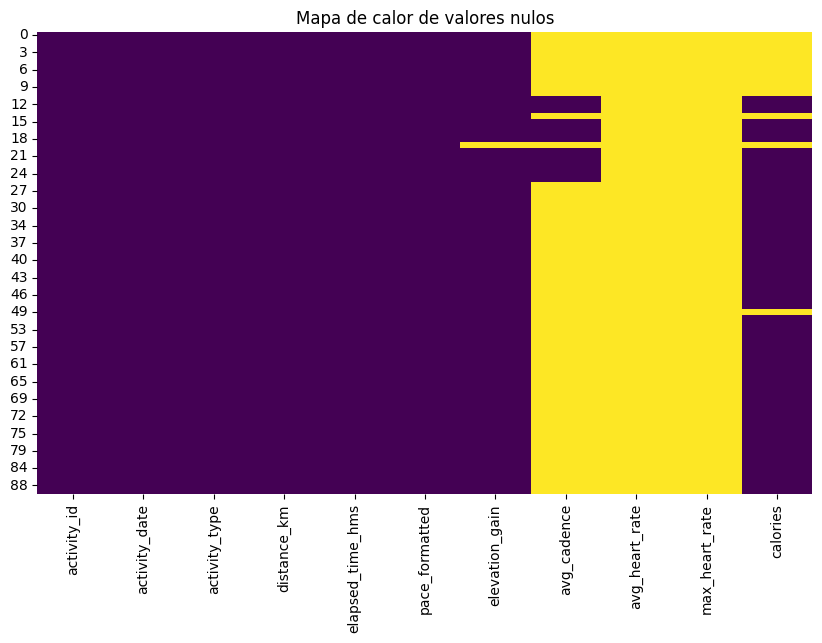

Estadísticos de variables seleccionadas:
       distance_km  pace_formatted     calories
count    80.000000        80.00000    66.000000
mean      8.563875         5.60325   437.893939
std       4.352537         0.98810   262.934629
min       0.200000         4.39000     8.000000
25%       5.822500         5.10000   307.250000
50%       8.000000         5.32500   385.000000
75%      10.480000         6.04750   479.000000
max      22.870000        11.22000  1256.000000


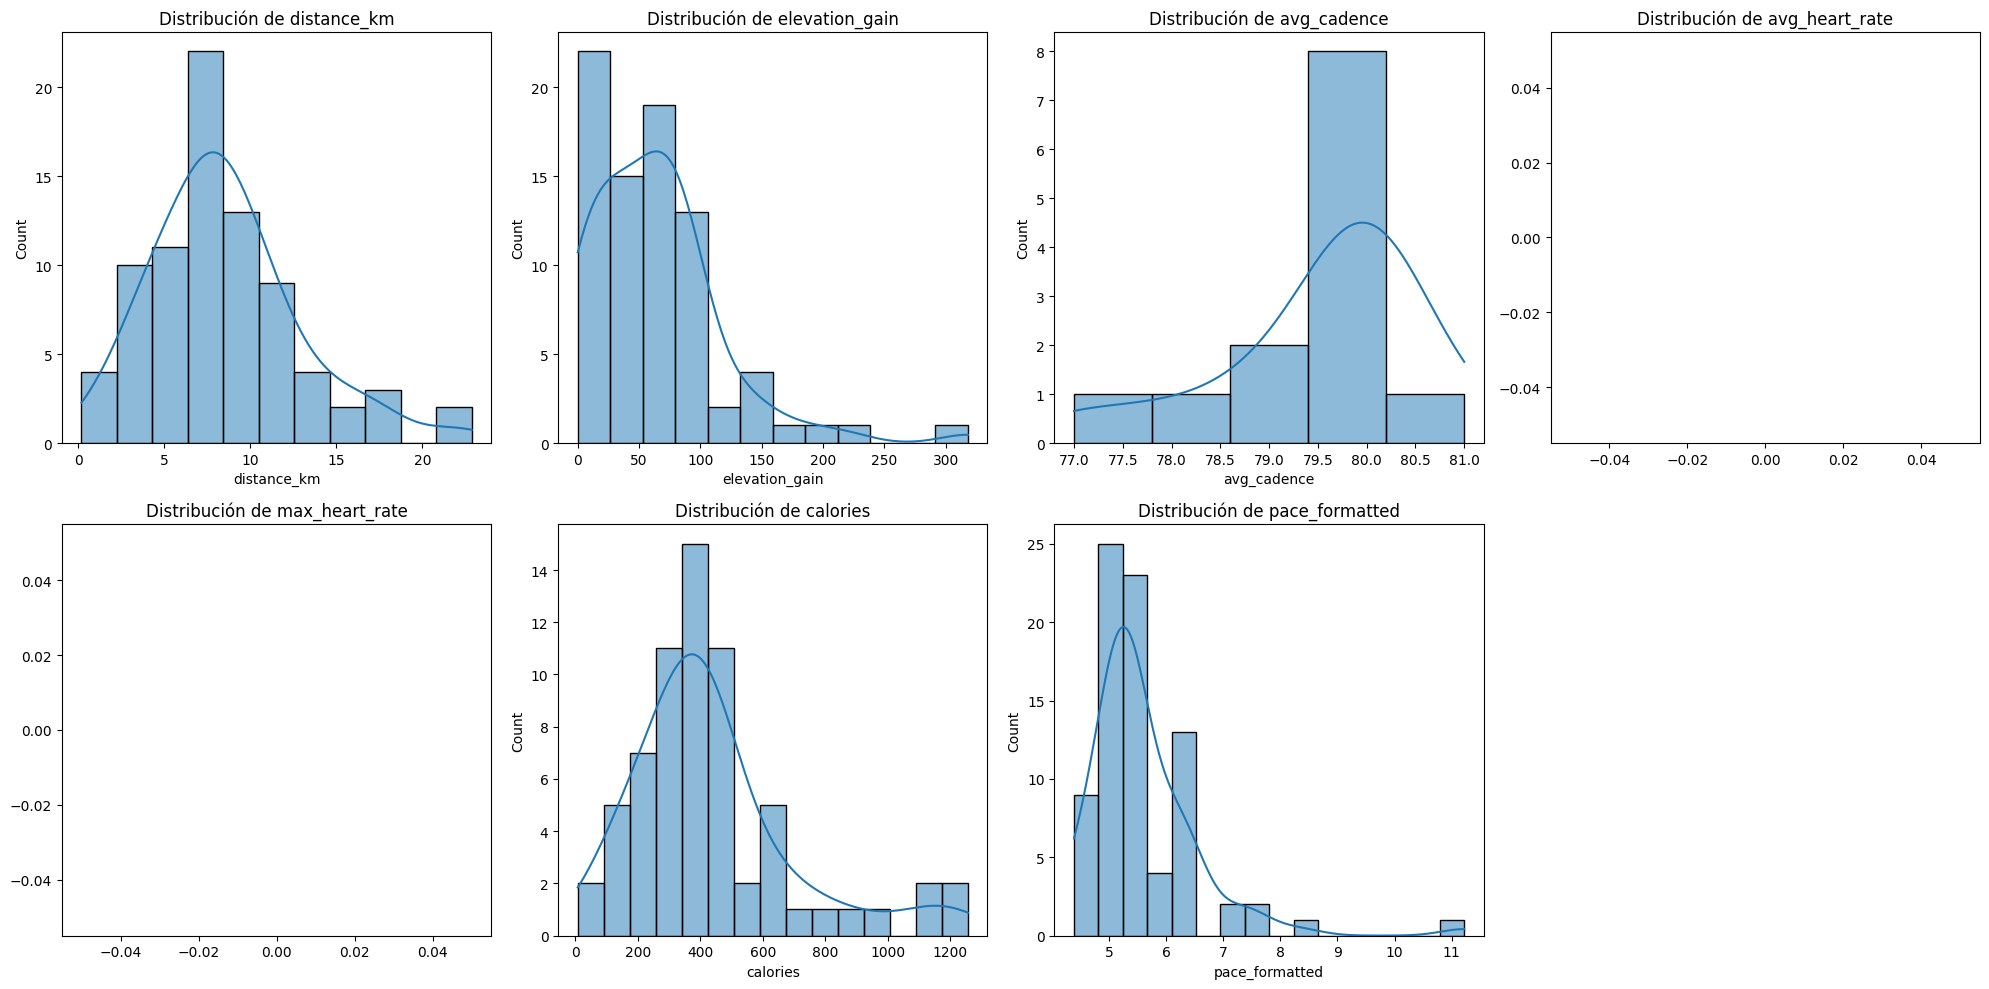

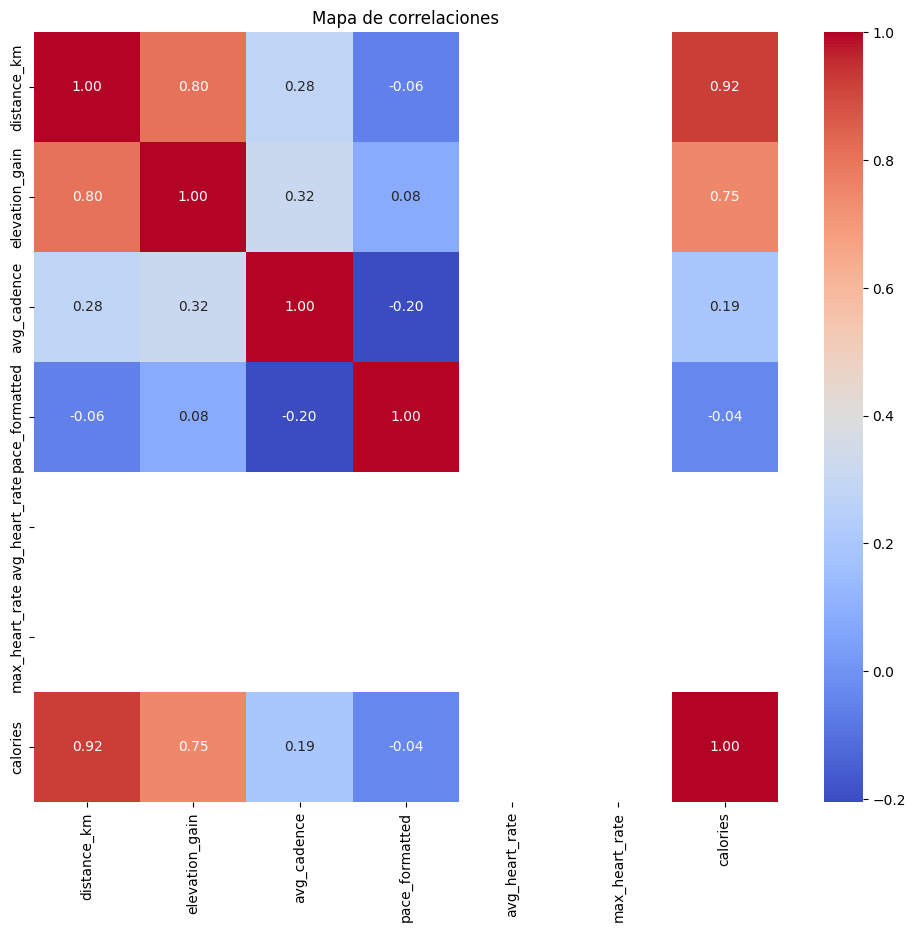

In [ ]:
def EDA(data):
    # Seleccionar solo las columnas relevantes
    columnas = [
        'activity_id', 'activity_date', 'activity_type',
        'distance_km', 'elapsed_time_hms',
        'pace_formatted', 'elevation_gain', 'avg_cadence',
        'avg_heart_rate', 'max_heart_rate', 'calories'
    ]
    data = data[columnas]

    # Gráficos para ver nulos
    if data.isnull().sum().sum() == 0:
        print("No hay valores nulos en las variables seleccionadas.")
    else:
        plt.figure(figsize=(10,6))
        sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
        plt.title('Mapa de calor de valores nulos')
        plt.show()

    # Estadísticos de variables seleccionadas
    print("Estadísticos de variables seleccionadas:")
    print(data[['distance_km', 'pace_formatted', 'calories']].describe())

    # Distribución de variables continuas en una sola imagen
    dist_vars = ['distance_km', 'elevation_gain', 'avg_cadence', 'avg_heart_rate', 'max_heart_rate', 'calories', 'pace_formatted']
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    axes = axes.flatten()

    for i, var in enumerate(dist_vars):
        if i < len(axes):
            ax = axes[i]
            if data[var].dtype == 'object':
                data[var].value_counts().plot(kind='bar', ax=ax)
                ax.set_ylabel('Frecuencia')
            else:
                sns.histplot(data[var].dropna(), kde=True, ax=ax)
            ax.set_title(f'Distribución de {var}')

    # Eliminar el subplot vacío si hay menos variables que subplots
    for j in range(len(dist_vars), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

    # Mapa de correlaciones (todas las variables numéricas relevantes)
    plt.figure(figsize=(12,10))
    corr_vars = ['distance_km', 'elevation_gain', 'avg_cadence','pace_formatted', 'avg_heart_rate', 'max_heart_rate', 'calories']
    corr = data[corr_vars].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Mapa de correlaciones')
    plt.show()

EDA(strava_limpio)